In [ ]:
# requirements.txt
# python==3.8.10
# matplotlib==3.7.2
# numpy==1.23.5
# tensorcircuit==0.11.0
# tensorflow==2.9.0
# tqdm==4.66.1


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import numpy as np
import tensorcircuit as tc
import random
from tqdm import tqdm
import sys
from tensorflow.python.ops.numpy_ops import np_config
import matplotlib.pyplot as plt
np_config.enable_numpy_behavior()

K = tc.set_backend("tensorflow")
tc.set_dtype(f"complex{128}")

('complex128', 'float64')

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

In [3]:
T = 30  
N = 2
N_time = N      # by default, N_time = N
EPOCHS = 200
L_time_rho = 5  # L_{\mathcal{T}} in paper
L_pre_rho = 1   # L in paper
batch_size = 16
num_mixed = 2
lamda = 0.02    # lambda
lr = 0.3
final_lr = 0.01
decay_steps = 200
type_target_state = "random_mixed_state"     # "random_pure_state" or "random_mixed_state"
model = "QGDM"  # "QGDM" or "RQGDM"
final_target_state = True
jit_flat = True
cm_state = tf.convert_to_tensor(np.identity(2 ** N, dtype=np.complex64) / 2 ** N)  # The completely mixed state.

In [4]:
def get_target_state():
    qubit_list = [i for i in range(N)]

    if type_target_state == "random_pure_state":
        cir = tc.DMCircuit(N)
        # random_theta = np.random.uniform(0, np.pi, size=[args.N * 4])
        random_theta = tf.random.uniform(shape=[N * 4], minval=0.00001, maxval=np.pi, dtype=tf.float64)
        index = 0
        for n in qubit_list:
            cir.RX(n, theta=random_theta[index])
            index += 1
            cir.RZ(n, theta=random_theta[index])
            index += 1
            cir.RX(n, theta=random_theta[index])
            index += 1
        if N == 2:
            cir.CRX(0, 1, theta=random_theta[index])
            index += 1
        elif N > 2:
            for n0, n1 in zip(qubit_list[:-1], qubit_list[1:]):
                cir.CRX(n0, n1, theta=random_theta[index])
                index += 1
            cir.CRX(qubit_list[-1], qubit_list[0], theta=random_theta[index])
            index += 1
        return cir.densitymatrix(reuse=False)

    elif type_target_state == "random_mixed_state":
        prob_vector = tf.random.uniform(shape=[num_mixed], minval=0.00001, maxval=1, dtype=tf.float64)
        # prob_vector = np.random.uniform(0, 1, size=[args.num_mixed])
        prob_vector = tf.nn.softmax(prob_vector)  # softmax operation
        random_theta = tf.random.uniform(shape=[num_mixed, N * 4], minval=0., maxval=np.pi, dtype=tf.float64)
        # random_theta = np.random.uniform(0, np.pi, size=[args.num_mixed, args.N * 4])
        state_list = []
        for i in range(num_mixed):
            cir = tc.DMCircuit(N)
            index = 0
            for n in qubit_list:
                cir.RX(n, theta=random_theta[i][index])
                index += 1
                cir.RZ(n, theta=random_theta[i][index])
                index += 1
                cir.RX(n, theta=random_theta[i][index])
                index += 1
            if N == 2:
                cir.CRX(0, 1, theta=random_theta[i][index])
                index += 1
            elif N > 2:
                for n0, n1 in zip(qubit_list[:-1], qubit_list[1:]):
                    cir.CRX(n0, n1, theta=random_theta[i][index])
                    index += 1
                cir.CRX(qubit_list[-1], qubit_list[0], theta=random_theta[i][index])
                index += 1
            state_list.append(prob_vector[i] * cir.densitymatrix(reuse=False))
        dm = tf.reduce_sum(state_list, axis=0)
        return dm

In [5]:
# Denoising circuit
def PQC(qubit_list, cir, theta, L, index=0):
    """     PQC      """

    for repeat_time in range(1, L + 1):
        for n in qubit_list:
            cir.RZ(n, theta=theta[index])
            index += 1

        for n in qubit_list:
            cir.RX(n, theta=theta[index])
            index += 1

        for n0 in qubit_list[:-1]:
            for n1 in qubit_list[1:]:
                if n0 != n1 and n0 < n1:
                    cir.exp1(n0, n1, unitary=tc.gates._xx_matrix, theta=theta[index])
                    index += 1

    for n in qubit_list:
        cir.RZ(n, theta=theta[index])
        index += 1

    for n in qubit_list:
        cir.RX(n, theta=theta[index])
        index += 1
    
    return cir, index

In [6]:
# timestep embedding circuit
def get_time_emb_rho_no_jit(t, theta):
    # print("jitting")
    qubit_list = [i for i in range(N_time)]
    t_angle = (np.pi / T) * (t - 1)
    cir = tc.DMCircuit(N_time)
    """     Time embedding      """
    # for n in qubit_list:
    #     cir.RX(n, theta=t_angle)
    #     cir.RZ(n, theta=t_angle)
    #     cir.RX(n, theta=t_angle)
    # cir = PQC(qubit_list, cir, theta, L=args.L_time_rho)
    index = 0
    if N_time > 4:
        a = [i for i in range(N_time) if i % 2 == 0]
        b = [i for i in range(N_time) if (i + 1) % 2 == 0]
    for i in range(L_time_rho):
        for n in range(N_time):
            cir.RX(n, theta=t_angle)

        if N_time == 1:
            pass

        elif N_time == 2:
            cir.exp1(0, 1, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1

        elif N_time == 3:
            cir.exp1(0, 1, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(1, 2, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            # cir.exp1(2, 0, unitary=tc.gates._zz_matrix, theta=theta[index])
            # index += 1

        elif N_time == 4:
            cir.exp1(0, 1, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(2, 3, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(1, 2, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(3, 0, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
        elif N_time == 5:
            cir.exp1(0, 1, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(2, 3, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(1, 2, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(3, 4, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
        elif N_time == 6:
            cir.exp1(0, 1, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(2, 3, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(4, 5, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(1, 2, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(3, 4, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(5, 0, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
        elif N_time == 7:
            cir.exp1(0, 1, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(2, 3, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(4, 5, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(1, 2, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(3, 4, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(5, 6, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
        elif N_time == 8:
            cir.exp1(0, 1, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(2, 3, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(4, 5, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(6, 7, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(1, 2, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(3, 4, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(5, 6, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
            cir.exp1(7, 0, unitary=tc.gates._zz_matrix, theta=theta[index])
            index += 1
        for n in range(N_time):
            cir.RY(n, theta=theta[index])
            index += 1

    for n in range(N_time):
        cir.RX(n, theta=t_angle)

    return cir.densitymatrix()

In [7]:
# backward process
def get_pre_rho_t_1_no_jit(theta, rho_t, time_emb_rho):
    if model == "QGDM":

        dminputs = K.kron(rho_t, time_emb_rho)
        qubit_list = [i for i in range(N + N_time)]
        cir = tc.DMCircuit(N + N_time, dminputs=dminputs)
        """     PQC      """
        cir, _ = PQC(qubit_list, cir, theta, L=L_pre_rho)
        # The first N_time qubits will be traced out.

        return tc.quantum.reduced_density_matrix(cir.densitymatrix(), cut=N_time)

    elif model == "RQGDM":
        # dminputs = K.kron(rho_t, time_emb_rho)
        qubit_list = [i for i in range(N)]
        qubit_list2 = [i for i in range(N+1)]
        cir = tc.DMCircuit(N, dminputs=rho_t)
        index = 0
        """     PQC      """
        cir, index = PQC(qubit_list, cir, theta, L=L_pre_rho, index=index)
        # The first N_time qubits will be traced out.
        reduced_dm = tc.quantum.reduced_density_matrix(cir.densitymatrix(), cut=N - 1)
        # print(reduced_dm)
        dminputs = K.kron(reduced_dm, time_emb_rho)
        cir2 = tc.DMCircuit(N + 1, dminputs=dminputs)
        """     PQC      """
        cir2, index = PQC(qubit_list2, cir2, theta, L=L_pre_rho, index=index)
        # The first N_time qubits will be traced out.
        return tc.quantum.reduced_density_matrix(cir2.densitymatrix(),  cut=1)


In [8]:
# Eq. (2) in paper
def cum_depolarizing_channel_no_jit(rho, p):
    return (1 - p) * cm_state + p * rho

In [9]:
# Section 3.2.2 Noise Schedule
def f(t):
    return np.cos((np.pi / 2) * (t / (T - 1) + 0.008) / (1 + 0.008)) ** 2
f0 = f(0)
alpha_cum = [f0]
for t in range(1, T):
    alpha_cum.append(f(t) / f0)
alpha_cum  = np.array(alpha_cum)
alpha_cum = tf.convert_to_tensor(alpha_cum)

In [10]:
# 
if jit_flat:
    cum_depolarizing_channel = tf.function(cum_depolarizing_channel_no_jit)
    get_time_emb_rho = tf.function(get_time_emb_rho_no_jit)
    get_pre_rho_t_1 = tf.function(get_pre_rho_t_1_no_jit)

else:
    cum_depolarizing_channel = cum_depolarizing_channel_no_jit
    get_time_emb_rho = get_time_emb_rho_no_jit
    get_pre_rho_t_1 = get_pre_rho_t_1_no_jit

loss 0.005510: 100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


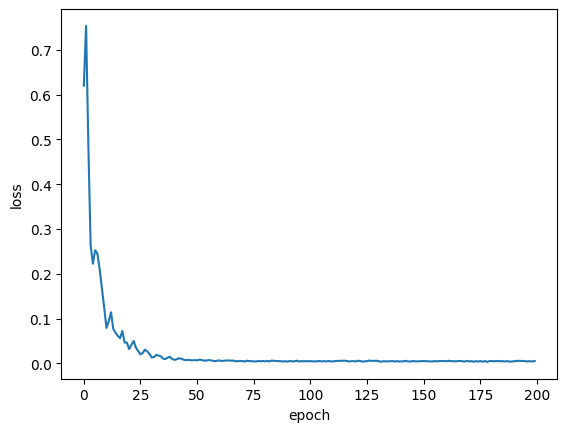

In [11]:
target_state = get_target_state()
time_step_list = [i for i in range(2, T + 1)]
time_step_list.reverse()  # [T, T-1, ..., 2, 1]

Ntime_big = 1 if N >= N_time else 2
double = 2 if model == "RQGDM" else 1
if N == 1:
    n_theta = Ntime_big * 4 * N * (L_pre_rho + 1) + L_pre_rho
else:
    n_theta = Ntime_big * double * (int(4 * N * (L_pre_rho + 1) + L_pre_rho * 2 * N * (2 * N - 1) / 2) + 1)

# 
Theta = tf.Variable(tf.random.uniform(shape=[2, n_theta], minval=0., maxval=np.pi, dtype=tf.float64))
tqdm_bar = tqdm(range(EPOCHS))

schedules = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=lr, decay_steps=decay_steps, alpha=final_lr / lr)
opt = tf.optimizers.Adam(learning_rate=schedules)
loss_list = []

# training
for epoch in tqdm_bar:
    time_loss, fidelity, loss, epoch_loss_list, = [], 0, 0, []
    time_list = np.random.choice(time_step_list, size=[batch_size], replace=False)
    time_list = np.concatenate([[1], time_list])
    
    with tf.GradientTape() as tape:
        tape.watch(Theta)
        
        for t in time_list:  # 10 9 8 7 .. 1
            # get target state \rho^{true}_{t-1}
            if t != 1:  # T T-1 T-2 ... 4 3 2
                rho_t_1 = cum_depolarizing_channel(rho=target_state, p=alpha_cum[t - 2])
            else:  # 1
                if final_target_state:
                    rho_t_1 = target_state
                else:
                    rho_t_1 = cum_depolarizing_channel(rho=target_state, p=tf.convert_to_tensor([0.9999]))
        
            rho_t = cum_depolarizing_channel(rho=target_state, p=alpha_cum[t - 1])  #
        
            time_emb_rho = get_time_emb_rho(theta=Theta[0], t=t)
            pre_rho_t_1 = get_pre_rho_t_1(theta=Theta[1], rho_t=rho_t, time_emb_rho=time_emb_rho)
            # compute quantum state fidelity
            try:
                fid = tc.quantum.fidelity(rho_t_1, pre_rho_t_1)
            except:
                print(epoch, t, rho_t, pre_rho_t_1, pre_rho_t_1, time_emb_rho,
                      pre_rho_t_1, Theta, grad)
                sys.exit()
            l = 1 - fid
            epoch_loss_list.append(l * lamda if t != 1 else l)
            fidelity += fid

        loss = epoch_loss_list[0] + tf.reduce_mean(epoch_loss_list[1:])
    tqdm_bar.set_description("loss %f" % float(loss))  # 设置描述
    grad = tape.gradient(loss, Theta)  # 求导

    opt.apply_gradients([(grad, var) for grad, var in zip([grad], [Theta])])
    loss_list.append(loss)
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [12]:
# generation
time_step_list = [i for i in range(1, T + 1)]
time_step_list.reverse()
if final_target_state:
    rho_t = cm_state
else:
    rho_t = cum_depolarizing_channel_no_jit(rho=target_state, p=alpha_cum[-1])
gene_real_list = []
gene_imag_list = []
generation_fidelity_list = []
time_emb_rho_list = {}

for t in time_step_list:
    time_emb_rho = get_time_emb_rho_no_jit(theta=Theta[0], t=t)
    time_emb_rho_list.update({t: np.array(time_emb_rho)})
    pre_rho_t_1 = get_pre_rho_t_1_no_jit(theta=Theta[1], rho_t=rho_t, time_emb_rho=time_emb_rho)

    fid = tc.quantum.fidelity(target_state, pre_rho_t_1)
    print(t, fid)
    generation_fidelity_list.append(fid)
    
    gene_real_list.append(tf.math.real(pre_rho_t_1))
    gene_imag_list.append(tf.math.imag(pre_rho_t_1))
    
    del rho_t
    rho_t = pre_rho_t_1
    


30 tf.Tensor(0.5694091118806546, shape=(), dtype=float64)
29 tf.Tensor(0.6405816775738131, shape=(), dtype=float64)
28 tf.Tensor(0.6877899612130246, shape=(), dtype=float64)
27 tf.Tensor(0.7066400548509734, shape=(), dtype=float64)
26 tf.Tensor(0.7077164067730615, shape=(), dtype=float64)
25 tf.Tensor(0.7040920648826753, shape=(), dtype=float64)
24 tf.Tensor(0.7061271143035021, shape=(), dtype=float64)
23 tf.Tensor(0.7185272847364031, shape=(), dtype=float64)
22 tf.Tensor(0.7398806824488218, shape=(), dtype=float64)
21 tf.Tensor(0.7648145024502897, shape=(), dtype=float64)
20 tf.Tensor(0.7884321520089963, shape=(), dtype=float64)
19 tf.Tensor(0.8106854256826533, shape=(), dtype=float64)
18 tf.Tensor(0.8358279020799908, shape=(), dtype=float64)
17 tf.Tensor(0.8657516201404072, shape=(), dtype=float64)
16 tf.Tensor(0.8965700055965488, shape=(), dtype=float64)
15 tf.Tensor(0.9231789898423741, shape=(), dtype=float64)
14 tf.Tensor(0.943044376623276, shape=(), dtype=float64)
13 tf.Tensor(0.

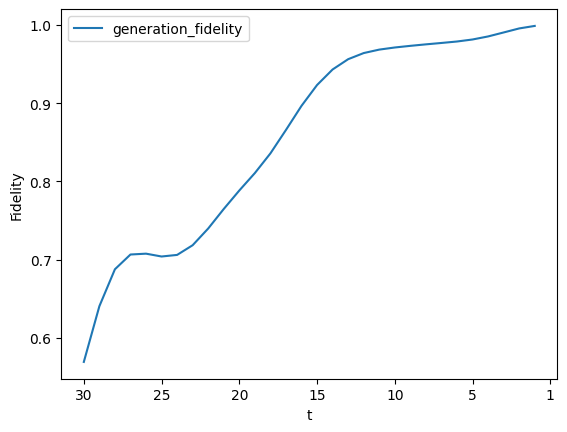

In [13]:
plt.plot(generation_fidelity_list, label="generation_fidelity")
plt.legend()
plt.xticks([0, 5, 10, 15, 20, 25, 30], ['30', '25', '20', '15', '10', '5', '1'])
plt.xlabel("t")
plt.ylabel("Fidelity")
plt.show()